# Tutorial 5: The sort-seq *E. Coli lac* promoter binding anlysis using a custom biophysical G-P maps

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Special imports
import mavenn
from tqdm.keras import TqdmCallback  # For better training progress visualization

The sort-seq MPRA data of Kinney et al., 2010. The authors in Ref. [1] used fluorescence-activated cell sorting, 
followed by deep sequencing, to assay gene expression levels from variant lac promoters in E. coli.
The data is available in MAVE-nn `load_example_dataset` function and it is called `'sortseq'`. 

In [2]:
# Choose dataset
data_name = 'sortseq'

print(f"Loading dataset '{data_name}' ")

# Load datset
data_df = mavenn.load_example_dataset(data_name)

# Get and report sequence length
L = len(data_df.loc[0, 'x'])
print(f'Sequence length: {L:d} amino acids')

# Preview dataset
data_df

Loading dataset 'sortseq' 
Sequence length: 75 amino acids


,set,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,x
0,training,0,1,0,0,0,0,0,0,0,0,AAAAAAAGTGAGTTAGCCAACTAATTAGGCACCGTACGCTTTATAG...
1,test,0,0,0,0,0,0,0,0,1,0,AAAAAATCTGAGTTAGCTTACTCATTAGGCACCCCAGGCTTGACAC...
2,test,0,0,0,0,0,0,1,0,0,0,AAAAAATCTGAGTTTGCTCACTCTATCGGCACCCCAGTCTTTACAC...
3,training,0,0,0,0,0,0,0,0,0,1,AAAAAATGAGAGTTAGTTCACTCATTCGGCACCACAGGCTTTACAA...
4,training,0,0,0,0,0,0,0,0,0,1,AAAAAATGGGTGTTAGCTCTATCATTAGGCACCCCCGGCTTTACAC...
...,...,...,...,...,...,...,...,...,...,...,...,...
50513,validation,0,0,0,1,0,0,0,0,0,0,TTTTGCAGAGTGTCAGCCCACTCATTACGCACCGCAGCCGTTACAC...
50514,test,0,0,0,0,0,0,0,0,1,0,TTTTTATGTGAGTTAGCTCACTCATTCGGCACCCTAGGCTTTACAC...
50515,training,0,0,0,1,0,0,0,0,0,0,TTTTTATGTGAGTTTGCTCACTCATGTGGCACCTAAGGCTTTACGC...
50516,training,1,0,0,0,0,0,0,0,0,0,TTTTTATGTGGGTTAGGTCGCGCATTAGGCACCGCAGGCTTTACCC...


In [3]:
# Split dataset
trainval_df, test_df = mavenn.split_dataset(data_df)

# Show dataset sizes
print(f'Train + val set size : {len(trainval_df):6,d} observations')
print(f'Test set size        : {len(test_df):6,d} observations')

# Preview trainval_df
trainval_df

Training set   :   30,516 observations (  60.41%)
Validation set :   10,067 observations (  19.93%)
Test set       :    9,935 observations (  19.67%)
-------------------------------------------------
Total dataset  :   50,518 observations ( 100.00%)

Train + val set size : 40,583 observations
Test set size        :  9,935 observations


,validation,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,x
0,False,0,1,0,0,0,0,0,0,0,0,AAAAAAAGTGAGTTAGCCAACTAATTAGGCACCGTACGCTTTATAG...
1,False,0,0,0,0,0,0,0,0,0,1,AAAAAATGAGAGTTAGTTCACTCATTCGGCACCACAGGCTTTACAA...
2,False,0,0,0,0,0,0,0,0,0,1,AAAAAATGGGTGTTAGCTCTATCATTAGGCACCCCCGGCTTTACAC...
3,False,0,1,0,0,0,0,0,0,0,0,AAAAAATGTCAGTTAGCTGACTCATTAGGCACCCCTGGCTTTACGT...
4,True,0,0,0,0,0,0,1,0,0,0,AAAAAATGTGAGAAAGCTCACTCCTTTGGCACCGCAGGCTTTACAC...
...,...,...,...,...,...,...,...,...,...,...,...,...
40578,True,0,1,0,0,0,0,0,0,0,0,TTTTGATGTGGGTTTGCTCTCTCTTCAGGCACCCCACGCTTTACGC...
40579,True,0,0,0,1,0,0,0,0,0,0,TTTTGCAGAGTGTCAGCCCACTCATTACGCACCGCAGCCGTTACAC...
40580,False,0,0,0,1,0,0,0,0,0,0,TTTTTATGTGAGTTTGCTCACTCATGTGGCACCTAAGGCTTTACGC...
40581,False,1,0,0,0,0,0,0,0,0,0,TTTTTATGTGGGTTAGGTCGCGCATTAGGCACCGCAGGCTTTACCC...


Training data are the count columns (10 columns) of the above dataset.

In [4]:
# Get the length of the sequence
L = len(data_df['x'][0])
# Get the column index for the counts
y_cols = trainval_df.columns[1:-1]
# Get the number of count columns
len_y_cols = len(y_cols)

## Training

A four-state thermodynamic model for transcriptional activation at *E. coli lac* promoter which proposed in Ref. [1] is trained here using MAVE-NN. 
Here, $\Delta G_R$ and  $\Delta G_C$ are RNAP-DNA and CRP-DNA binding Gibbs free energies and CRP-RNAP interaction energy is represented by a scalar $\Delta G_I$.
The four-state thermodynamic model is summarized below:

| microstates                                   | Gibbs free energies                   | activity |
|:----------------------------------------------|:--------------------------------------|:---------|
| free DNA                                      | 0                                     | 0        |
| CRP-DNA binding                               | $\Delta G_C$                          | 0        |
| RNAP-DNA binding                              | $\Delta G_R$                          | 1        |
| CRP and RNAP both bounded to DNA and interact | $\Delta G_C+ \Delta G_R + \Delta G_I$ | 1        |

The rate of transcription `tr_rate` has the following form:
$$
tr_{\text{rate}} = t_{sat} \frac {\exp(-\Delta G_R)+ \exp(-\Delta G_C-\Delta G_R-\Delta G_I)}{1+\exp(-\Delta G_C)+ \exp(-\Delta G_R)+ \exp(-\Delta G_C- \Delta G_R- \Delta G_I)} 
$$ 
in which $t_{sat}$ is the transcription rate resulting from full RNAP occupancy. 

Here, the $\Delta G_C$ and $\Delta G_R$ are trainable matrices (weights of the neural network) and $\Delta G_I$ and $t_{sat}$ are trainable scalars.

To fit the above thermodynamic models, we used the **Custom G-P maps** layer implemented in `'mavenn.src.layers.gpmap'`.
For the detailed discussion on how to use the MAVE-NN custom G-P maps layer, checkout the thermodynamic model for IgG binding by GB1 tutorial.

In [5]:
from mavenn.src.layers.gpmap import CustomGPMapLayer


# Tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Layer, Dense


class ThermodynamicLayer(CustomGPMapLayer):
    """
    Represents a four-stage thermodynamic model
    containing the states:
    1. free DNA 
    2. CPR-DNA binding
    3. RNAP-DNA binding
    4. CPR and RNAP both bounded to DNA and interact
    """

    def __init__(self,
                 tf_start,
                 tf_end,
                 rnap_start,
                 rnap_end,
                 C,
                 regularizer,
                 *args, **kwargs):
        """Construct layer instance."""

        # set attributes
        self.tf_start = tf_start             # transcription factor starting position
        self.tf_end = tf_end                 # transcription factor ending position
        self.L_tf = tf_end - tf_start        # length of transcription factor
        self.rnap_start = rnap_start         # RNAP starting position
        self.rnap_end = rnap_end             # RNAP ending position
        self.L_rnap = rnap_end - rnap_start  # length of RNAP
        self.C = C                           # alphabet represent sequence
        # regulariztion on weights
        self.regularizer = tf.keras.regularizers.L2(regularizer)

        super().__init__(*args, **kwargs)

    def build(self, input_shape):
        """Build layer."""

        # define bias/chemical potential weight for TF/CRP energy
        self.theta_tf_0 = self.add_weight(name='theta_tf_0',
                                          shape=(1,),
                                          initializer=Constant(1.),
                                          trainable=True,
                                          regularizer=self.regularizer)

        # define bias/chemical potential weight for rnap energy
        self.theta_rnap_0 = self.add_weight(name='theta_rnap_0',
                                            shape=(1,),
                                            initializer=Constant(1.),
                                            trainable=True,
                                            regularizer=self.regularizer)

        # define theta_TF_lc parameters
        theta_tf_shape = (1, self.L_tf, self.C)
        # initialize the theta_tf
        theta_tf_init = np.random.randn(*theta_tf_shape)/np.sqrt(self.L_tf)
        # define the weights of the layer corresponds to theta_tf
        self.theta_tf = self.add_weight(name='theta_tf',
                                        shape=theta_tf_shape,
                                        initializer=Constant(theta_tf_init),
                                        trainable=True,
                                        regularizer=self.regularizer)

        # define theta_rnap parameters
        theta_rnap_shape = (1, self.L_rnap, self.C)
        # initialize the theta_rnap
        theta_rnap_init = np.random.randn(
            *theta_rnap_shape)/np.sqrt(self.L_rnap)
        # define the weights of the layer corresponds to theta_rnap
        self.theta_rnap = self.add_weight(name='theta_rnap',
                                          shape=theta_rnap_shape,
                                          initializer=Constant(
                                              theta_rnap_init),
                                          trainable=True,
                                          regularizer=self.regularizer)

        # define trainable real number G_I, representing interaction Gibbs energy
        self.G_I = self.add_weight(name='G_I',
                                   shape=(1,),
                                   initializer=Constant(0),
                                   trainable=True,
                                   regularizer=tf.keras.regularizers.L2(0))
        # define trainable real number tsat, representing the transcription for
        # full RNAP occupancy.
        self.tsat = self.add_weight(name='tsat',
                                    shape=(1,),
                                    initializer=Constant(1.),
                                    trainable=True,
                                    regularizer=tf.keras.regularizers.L2(0))

        # Call superclass build
        super().build(input_shape)

    def call(self, x):
        """Process layer input and return output.

        x: (tensor)
            Input tensor that represents one-hot encoded 
            sequence values. 
        """

        # extract locations of binding sites from entire lac-promoter sequence.
        # for transcription factor and rnap
        x_tf = x[:, self.C * self.tf_start:self.C * self.tf_end]
        x_rnap = x[:, self.C * self.rnap_start: self.C * self.rnap_end]

        # reshape according to tf and rnap lengths.
        x_tf = tf.reshape(x_tf, [-1, self.L_tf, self.C])
        x_rnap = tf.reshape(x_rnap, [-1, self.L_rnap, self.C])

        # compute delta G for crp binding
        G_C = self.theta_tf_0 + \
            tf.reshape(K.sum(self.theta_tf * x_tf, axis=[1, 2]),
                       shape=[-1, 1])

        # compute delta G for rnap binding
        G_R = self.theta_rnap_0 + \
            tf.reshape(K.sum(self.theta_rnap * x_rnap, axis=[1, 2]),
                       shape=[-1, 1])

        # compute the rate of transcription tr_rate
        # numerator of the rate
        numerator_of_rate = (self.tsat)*(K.exp(-G_R) +
                                         K.exp(-G_C-G_R-self.G_I))
        # denomerator of the rate
        denom_of_rate = 1.0 + K.exp(-G_C) + \
            K.exp(-G_R) + K.exp(-G_C-G_R-self.G_I)
        tr_rate = numerator_of_rate/denom_of_rate

        return tr_rate

    def set_params(self, **kwargs):
        """Set values of layer parameters."""
        assert False

    def get_params(self):
        """Get values of layer parameters."""
        param_dict = {}
        param_dict['theta_tf_0'] = np.float(self.theta_tf_0)
        param_dict['theta_rnap_0'] = np.float(self.theta_rnap_0)
        param_dict['theta_tf'] = np.squeeze(self.theta_tf)
        param_dict['theta_rnap'] = np.squeeze(self.theta_rnap)
        param_dict['G_I'] = np.float(self.G_I)
        param_dict['tsat'] = np.float(self.tsat)
        return param_dict

### Training the Model

In [6]:
# define custom gp_map parameters dictionary
gpmap_kwargs = {'tf_start': 1,  # starting position of the CRP
                'tf_end': 27,  # ending position of the CRP
                'rnap_start': 34,  # starting position of the RNAP
                'rnap_end': 75,   # ending position of the RNAP
                'C': 4,           # number of alphabets (here is 4, 'ATCG')
                'regularizer': 0.1}  # weights regularization.

# Create model
model = mavenn.Model(L=L,
                     Y=len_y_cols,
                     alphabet='dna',
                     regression_type='MPA',
                     gpmap_type='custom',
                     gpmap_kwargs=gpmap_kwargs,
                     custom_gpmap=ThermodynamicLayer)

# Set training data
model.set_data(x=trainval_df['x'],
               y=trainval_df[y_cols],
               validation_flags=trainval_df['validation'],
               shuffle=True)

# # Fit model to data
model.fit(learning_rate=.00025,
          epochs=1000,
          batch_size=100,
          early_stopping=True,
          early_stopping_patience=25,
          linear_initialization=False,
          verbose=False,
          callbacks=[TqdmCallback(verbose=0)])

N = 40,583 observations set as training data.
Using 24.8% for validation.
Data shuffled.


  0%|          | 0/1000 [00:00<?, ?epoch/s]

Time to set data: 0.75 sec.


100%|██████████| 1000/1000 [10:04<00:00,  1.65epoch/s, loss=199, I_var=0.65, val_loss=198, val_I_var=0.658]

Training time: 605.2 seconds


In [7]:
# Compute predictive information on test data
I_pred, dI_pred = model.I_predictive(x=test_df['x'], y=test_df[y_cols])
print(f'test_I_pred: {I_pred:.3f} +- {dI_pred:.3f} bits')

test_I_pred: 0.674 +- 0.010 bits


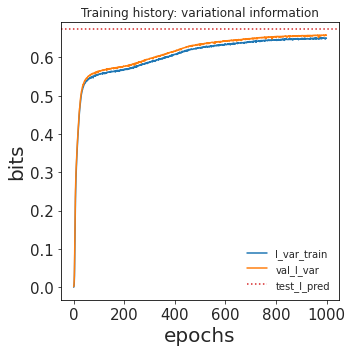

In [8]:
# Create figure and axes for plotting
fig, ax = plt.subplots(1, 1, figsize=[5, 5])

# Plot I_var_train, the variational information on training data as a function of epoch
ax.plot(model.history['I_var'],
        label=r'I_var_train')

# Plot I_var_val, the variational information on validation data as a function of epoch
ax.plot(model.history['val_I_var'],
        label=r'val_I_var')

# Show I_pred_test, the predictive information of the final model on test data
ax.axhline(I_pred, color='C3', linestyle=':',
           label=r'test_I_pred')

# Style plot
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('Training history: variational information')
ax.legend()

plt.tight_layout()

In [9]:
# Get the trained model parameters
# Retrieve G-P map parameter dict and view dict keys
param_dict = model.layer_gpmap.get_params()
param_dict.keys()

dict_keys(['theta_tf_0', 'theta_rnap_0', 'theta_tf', 'theta_rnap', 'G_I', 'tsat'])

Authors in Ref. [1], reported they inferred CRP-RNAP interaction energy to be $\Delta G_I = −3.26$ kcal∕mol.
The MAVE-NN prediction is very similar to the reported value, while it is several order of magnitude faster 
than the method used in Ref. [1].

In [10]:
delta_G_I = param_dict['G_I']  # Gibbs energy of Interaction (scalar)
print(f'CRP-RNAP interaction energy = {delta_G_I*0.62:.3f} k_cal/mol')

CRP-RNAP interaction energy = 2.890 k_cal/mol


In addition, we can represent the CRP-DNA $\Delta G_C$ and RNAP-DNA $\Delta G_R$ binding energies in
the weight matrix form. The weight matrices can be represented by sequence logos. To do that, we used the 
a Python package `Logomaker` which is also developed in our research group and is 
freely available [here](https://logomaker.readthedocs.io/en/latest/).
To represent the weight matrices in logo

(a) we get the trained `crp_weights` and `rnap_weights` values, 
(b) we convert them to the `pandas.DataFrame` with column names being the nucleotide strings. 

The `pandas.DataFrame` can easily imported in `Logomaker`. 
See the [documentation](https://logomaker.readthedocs.io/en/latest/) 
of `Logomaker` for detailed description of the parameters one can pass to make logos.

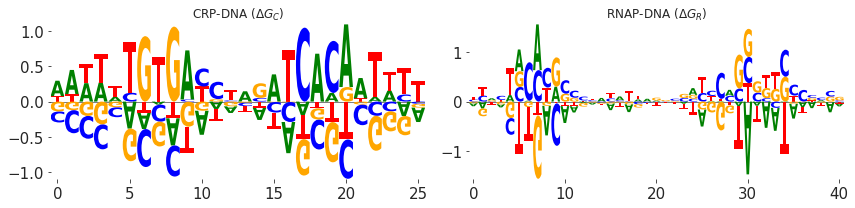

In [11]:
# import logomaker
import logomaker

# Get the \Delta G_C trained values (theta_tf)
crp_weights = param_dict['theta_tf']
# Get the \Delta G_R trained values (theta_rnap)
rnap_weights = param_dict['theta_rnap']
# Convert them to pandas dataframe
crp_df = pd.DataFrame(crp_weights, columns=model.alphabet)
rnap_df = pd.DataFrame(rnap_weights, columns=model.alphabet)


# plot logos
fig, axs = plt.subplots(1, 2, figsize=[12, 3])

# sequence logo for the CRP-DNA binding energy matrix
logo = logomaker.Logo(crp_df,  ax=axs[0], center_values=True)
axs[0].set_title('CRP-DNA ($\Delta G_C$)')
logo.style_spines(visible=False)


# sequence logo for the RNAP-DNA binding energy matrix
logo = logomaker.Logo(rnap_df, ax=axs[1], center_values=True)
axs[1].set_title('RNAP-DNA ($\Delta G_R$)')
logo.style_spines(visible=False)

plt.tight_layout()

## References

1. Kinney J, Murugan A, Callan C, Cox E (2010). Using deep sequencing to characterize the biophysical mechanism of a transcriptional regulatory sequence. [Proc Natl Acad Sci USA. 107(20):9158-9163](https://doi.org/10.1073/pnas.1004290107).